In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from google.cloud import bigquery

In [2]:
def estimate_bigquery_query_cost(bq_client, query):
    
    job_config = bigquery.QueryJobConfig()
    job_config.dry_run = True
    job_config.use_query_cache = False
    query_job = bq_client.query(

        (
           query
        ),
        job_config=job_config,
    )
    
    cost_euros = (query_job.total_bytes_processed / 1024 ** 4) * 6

    print(f"{query_job.total_bytes_processed} bytes will be processed , cost ~{cost_euros}$")

In [3]:
bigquery_client= bigquery.Client(project="ingka-energy-analytics-dev") # ingka-energy-solar-dev

In [30]:
# Download query results.
query_string = """
    SELECT 
        internal_search_type
        , count(1) as count_cat
    FROM `ingka-web-analytics-prod.web_data_v2.hits_events_and_pages` 
    WHERE 
        date_hit = '2022-07-02' 
        AND internal_search_type is not Null
    GROUP BY internal_search_type
    ORDER BY count_cat DESC
    LIMIT 1000
"""

estimate_bigquery_query_cost(bigquery_client, query_string) 

2510418036 bytes will be processed , cost ~0.013699271417863201$


In [31]:
df = (
    bigquery_client.query(query_string)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)

df

,internal_search_type,count_cat
0,hard_search,12228316
1,autocomplete,1847696
2,product_recent,448228
3,product_suggest,325364
4,related_searches,258568
5,category_suggest,192140
6,historical_searches,101270
7,popular_searches,30281
8,content_suggest,19775
9,planner_suggest,17032


In [27]:
indexing = df['internal_search_type'].str.contains('search') & ~df['internal_search_type'].str.contains('search').isna()
df.loc[indexing , 'event_action']

9                                            hard_search
57                                        search_actions
84                                      related_searches
102                               stock_check_search_box
149                                  historical_searches
171                                     popular_searches
180                                    loc_search_result
189                             collect_check_search_box
222                                     refined_searches
257                                      visual_searches
336                                               search
538                                       product_search
833        https://app.ltl.xpo.com/appjs/tracking/search
988    https://www.seeacareerwithus.com/search-jobs#s...
Name: event_action, dtype: object

In [32]:
# Download query results.
query_string = """
    SELECT 
        hit_timestamp
        , visitor_id
        , session_id
        , hit_type
        , event_category
        , website_market_short
        , website_language_short
        , page_title
        , internal_search_type
        , internal_search_term
    FROM `ingka-web-analytics-prod.web_data_v2.hits_events_and_pages` 
    WHERE 
        date_hit = '2022-07-02' 
        AND event_category like '%search%'
        AND internal_search_type = 'hard_search'
    LIMIT 1000
"""

estimate_bigquery_query_cost(bigquery_client, query_string) 

43824092571 bytes will be processed , cost ~0.23914668001998507$


In [ ]:
df = (
    bigquery_client.query(query_string)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)

df

In [3]:
def plot_hits(df:pd.DataFrame, groupvar:str):
    df_plot = pd.DataFrame(df.groupby(['date_hit',groupvar]).user_id.count()).reset_index()
    g = sns.FacetGrid(data=df_plot, hue=groupvar, height=5, aspect=5)

    g.map(sns.lineplot, 'date_hit', 'user_id')
    g.add_legend()
    plt.xticks(rotation=45)
    plt.suptitle(f'Hits per day by {groupvar}')

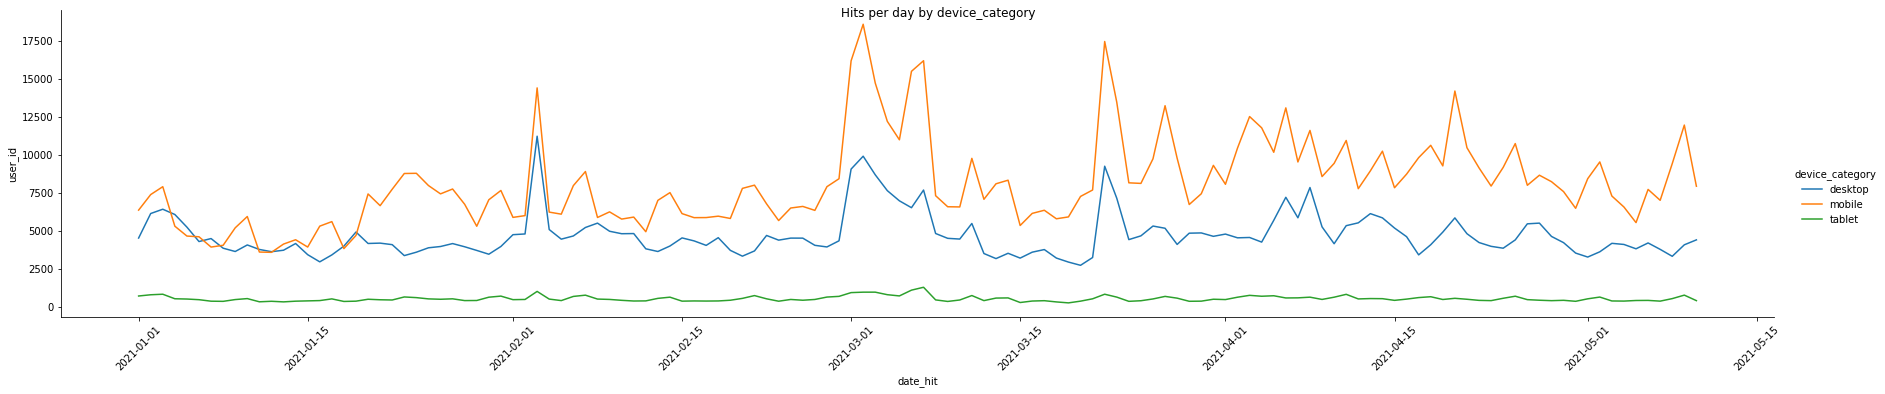

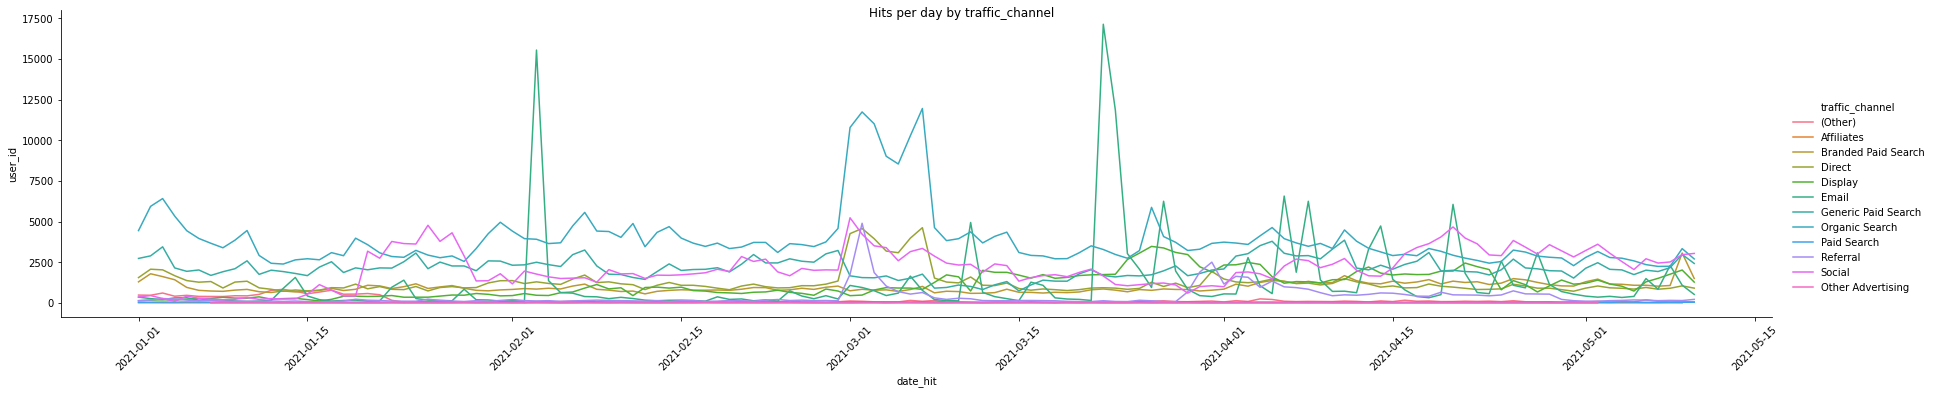

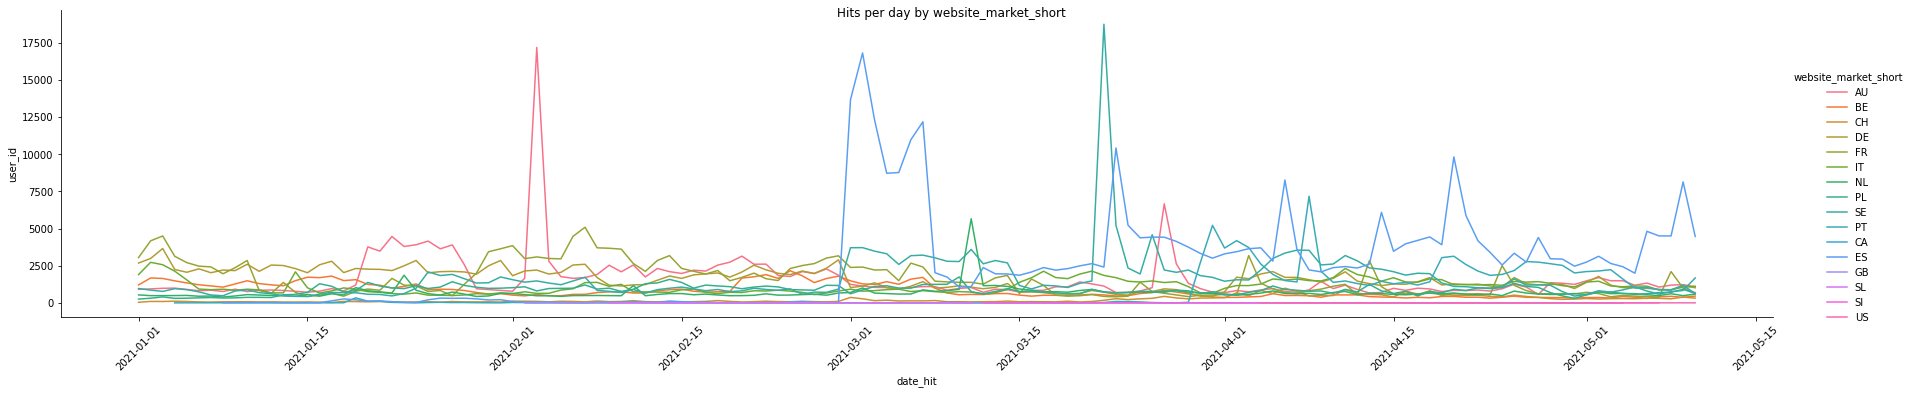

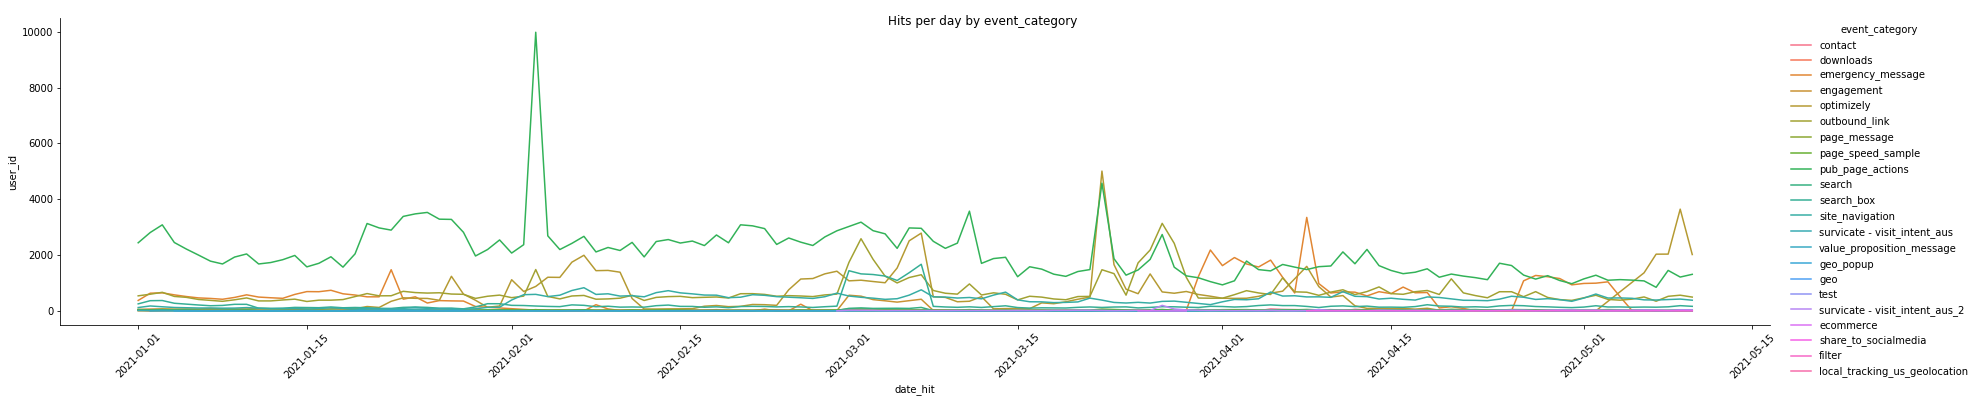

In [4]:
plot_hits(df=df, groupvar='device_category')
plot_hits(df=df, groupvar='traffic_channel')
plot_hits(df=df, groupvar='website_market_short')
plot_hits(df=df, groupvar='event_category')